In [115]:
import pandas as pd
import numpy as np
import plotly.express as px

import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import model_selection

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from yellowbrick.cluster import SilhouetteVisualizer
import sklearn.metrics as sm
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [116]:
data = pd.read_csv("Data/vgchartz-2024.csv")

In [117]:
# show all columns
pd.set_option("display.max_columns", None)

In [118]:
data.shape

(64016, 14)

In [119]:
data.head()

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


## General Cleaning

The different questions require different cleaning, so we start with a general cleaning, and clean for each question as needed

In [120]:
# We dont need the Last_update colmun for any of our research
    
data_general_clean = data.copy()


data_general_clean = data_general_clean.drop(["last_update"], axis=1)

In [121]:
data_general_clean.isnull().sum()

img                 0
title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
dtype: int64

In [122]:
data_general_clean.duplicated().sum()

np.int64(0)

In [123]:
# all of our questions is based on sale to validate the hypothesis, therefor we will drop all that dont have that data.

data_general_clean = data_general_clean.dropna(subset=["total_sales"])

In [124]:
data_general_clean.shape

(18922, 13)

In [125]:
data_general_clean.sample(5)


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date
2898,/games/boxart/4213179ccc.jpg,Hasbro Family Game Night,PS2,Misc,Electronic Arts,EA Bright Light,NaN,0.57,0.28,NaN,0.22,0.07,2008-11-11
11567,/games/boxart/full_1319238AmericaFrontccc.jpg,Hunting Simulator,PS4,Shooter,Bigben Interactive,Maximum Games,NaN,0.07,0.06,NaN,NaN,0.01,2017-07-11
3540,/games/boxart/5613667ccc.jpg,X-Men: Next Dimension,PS2,Fighting,Activision,Paradox Development,NaN,0.47,0.23,NaN,0.18,0.06,2002-10-15
17350,/games/boxart/full_3020931AmericaFrontccc.jpg,Surf's Up,GC,Sports,Ubisoft,Ubisoft Montreal,NaN,0.01,0.01,NaN,0.00,0.00,2007-06-01
14393,/games/boxart/full_a-game-of-thrones-genesis_9...,A Game of Thrones: Genesis,PC,Strategy,Focus Home Interactive,Cyanide,4.9,0.03,NaN,NaN,0.03,0.00,2011-09-28


In [126]:
data_general_clean.isnull().sum()

img                 0
title               0
console             0
genre               0
publisher           0
developer           4
critic_score    14796
total_sales         0
na_sales         6285
jp_sales        12196
pal_sales        6098
other_sales      3794
release_date       90
dtype: int64

In [127]:
# we figure that if there are total sales, and none in the others colmuns, it properly means that there somwhere
# is somthing round down, but the total sale is still valied 
data_general_clean[["na_sales", "jp_sales", "pal_sales", "other_sales"]] = data_general_clean[["na_sales", "jp_sales", "pal_sales", "other_sales"]].fillna(0)

In [128]:
data_general_clean.isnull().sum()

img                 0
title               0
console             0
genre               0
publisher           0
developer           4
critic_score    14796
total_sales         0
na_sales            0
jp_sales            0
pal_sales           0
other_sales         0
release_date       90
dtype: int64

In [129]:
# It's easier for us to visualize with a year and month seperate.
data_general_clean_date = data_general_clean.copy()

data_general_clean_date["release_date"] = pd.to_datetime(data_general_clean_date["release_date"])

data_general_clean_date["month"] = data_general_clean_date["release_date"].dt.month.astype("Int64")
data_general_clean_date["year"] = data_general_clean_date["release_date"].dt.year.astype("Int64")

data_general_clean_date.sample(5)

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,month,year
6938,/games/boxart/full_tron-evolution-battle-grids...,TRON: Evolution - Battle Grids,Wii,Racing,Disney Interactive Studios,n-Space,NaN,0.21,0.17,0.0,0.03,0.01,2010-12-07,12,2010
16234,/games/boxart/full_5542719AmericaFrontccc.jpg,Flashback,PS4,Platform,Microids,Paul Cuisset,NaN,0.01,0.01,0.0,0.00,0.00,2018-11-20,11,2018
15120,/games/boxart/full_6178826AmericaFrontccc.jpg,Tennis World Tour,NS,Sports,Bigben Interactive,Breakpoint Studio,NaN,0.02,0.02,0.0,0.00,0.00,2018-07-10,7,2018
17982,/games/boxart/full_18-wheels-of-steel-triple-p...,18 Wheels of Steel: Triple Pack,PC,Racing,Unknown,SCS Software,NaN,0.00,0.00,0.0,0.00,0.00,2011-01-28,1,2011
5544,/games/boxart/7363768ccc.gif,Harry Potter and the Sorcerer's Stone,PS2,Action,Electronic Arts,Warthog,NaN,0.28,0.14,0.0,0.11,0.04,2003-12-09,12,2003


In [130]:
# now when we have date and year in seperate colmuns we drop the release_date
data_general_clean_date_q1 = data_general_clean_date.dropna(subset=['release_date'])
data_general_clean_date_q1.isnull().sum()

img                 0
title               0
console             0
genre               0
publisher           0
developer           3
critic_score    14709
total_sales         0
na_sales            0
jp_sales            0
pal_sales           0
other_sales         0
release_date        0
month               0
year                0
dtype: int64

In [131]:
data_general_clean.describe()

,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,4126.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000
mean,7.101890,0.349113,0.176806,0.036357,0.101302,0.034411
std,1.439307,0.807462,0.423133,0.111918,0.330707,0.114541
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.300000,0.030000,0.000000,0.000000,0.000000,0.000000
50%,7.300000,0.120000,0.050000,0.000000,0.010000,0.010000
75%,8.100000,0.340000,0.170000,0.020000,0.070000,0.020000
max,10.000000,20.320000,9.760000,2.130000,9.850000,3.120000


## Question 1: When should a company release a game to maximize sales at launch?

In [132]:
# Base arguments for histogram
kwargs = {
    "x": "month",
    "y": "total_sales",
    "animation_frame": "year",
    "histfunc": "sum",  # aggregate sales if multiple entries per month
    "labels": {
        "total_sales": "Sales",
        "month": "Release Month",
        "year": "Release Year"
    },
    "title": "Monthly Release Histogram Animated by Year and Total Accumulated Sales"
}

# Add color only if category exists
if "category" in data_general_clean_date_q1.columns:
    kwargs["color"] = "category"

fig = px.histogram(data_general_clean_date_q1, **kwargs)

# Ensure months are in calendar order
fig.update_xaxes(categoryorder="array", categoryarray=[
    "Jan","Feb","Mar","Apr","May","Jun",
    "Jul","Aug","Sep","Oct","Nov","Dec"
])

# Reverse year order so animation starts at oldest year
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
fig.frames = sorted(fig.frames, key=lambda f: int(f.name))  # sort frames by year
fig.layout.sliders[0]["steps"] = sorted(fig.layout.sliders[0]["steps"], key=lambda s: int(s["label"]))

fig.show()
# TODO Change y scale 


The Months and years shows when the game was released, not the date of the sale. Sales are measured accumulatively. But we assume that sales are highest around the release date.
We can see a trend in later years around the month 10 and 11, which we speculate sales leading up to Christmas(the holidays). We can also see a slight trend around month 3 (March), we speculate that a lot of our data comes from games sold for NA. This could possibly be explained by holidays in NA, for example Spring break (TODO: research this!). (TODO: Research if there is a summer trend)

In [133]:
# Group by year and month, count rows
games_per_month = (
    data_general_clean_date_q1.groupby(["year", "month"])
      .size()
      .reset_index(name="count")   # number of games released
)

# Convert month numbers to strings
games_per_month["month"] = games_per_month["month"].astype(str)

# Force x-axis order (1–12 as strings)
fig.update_xaxes(
    categoryorder="array",
    categoryarray=[str(i) for i in range(1, 13)]
)

# TODO: Fix this!

games_per_month

,year,month,count
0,1977,1,2
1,1977,10,1
2,1978,1,7
3,1979,1,1
4,1980,1,2
...,...,...,...
388,2020,2,1
389,2020,4,1
390,2020,8,2
391,2020,10,1


In [134]:
kwargs = {
    "x": "month",
    "y": "count",                # already aggregated
    "animation_frame": "year",   # animate over years
    "labels": {
        "count": "Number of Released Games",
        "month": "Release Month",
        "year": "Release Year"
    },
    "title": "Monthly Game Releases Animated by Year"
}

# Add color only if category exists
if "category" in games_per_month.columns:
    kwargs["color"] = "category"

fig = px.bar(games_per_month, **kwargs)

# Ensure months appear in calendar order
fig.update_xaxes(categoryorder="array", categoryarray=[
    "Jan","Feb","Mar","Apr","May","Jun",
    "Jul","Aug","Sep","Oct","Nov","Dec"
])

# Sort frames so animation goes oldest → newest
fig.frames = sorted(fig.frames, key=lambda f: int(f.name))
fig.layout.sliders[0]["steps"] = sorted(fig.layout.sliders[0]["steps"], key=lambda s: int(s["label"]))

fig.show()


We want to see how many games are released over the years for specific months, to compare with the previous animation for sales.

## Question 2: Do video games form distinct clusters based on release period (old vs. new) and sales performance (high vs. low)?

In [135]:
data_general_clean_q2 = data_general_clean_date.copy()

data_general_clean_q2 = data_general_clean_date[["year", "month", "total_sales"]].copy()

data_general_clean_q2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18922 entries, 0 to 18921
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         18832 non-null  Int64  
 1   month        18832 non-null  Int64  
 2   total_sales  18922 non-null  float64
dtypes: Int64(2), float64(1)
memory usage: 628.3 KB


In [136]:
data_general_clean_q2 = data_general_clean_q2.dropna(subset=["year", "month"])

data_general_clean_q2["date"] = pd.to_datetime(dict(year=data_general_clean_q2["year"], month=data_general_clean_q2["month"], day=1))

# Sort by date just in case
data_general_clean_q2 = data_general_clean_q2.sort_values("date")

data_general_clean_q2_2 = data_general_clean_q2[["date", "total_sales"]].copy()

data_general_clean_q2_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18832 entries, 1102 to 14310
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         18832 non-null  datetime64[ns]
 1   total_sales  18832 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 441.4 KB


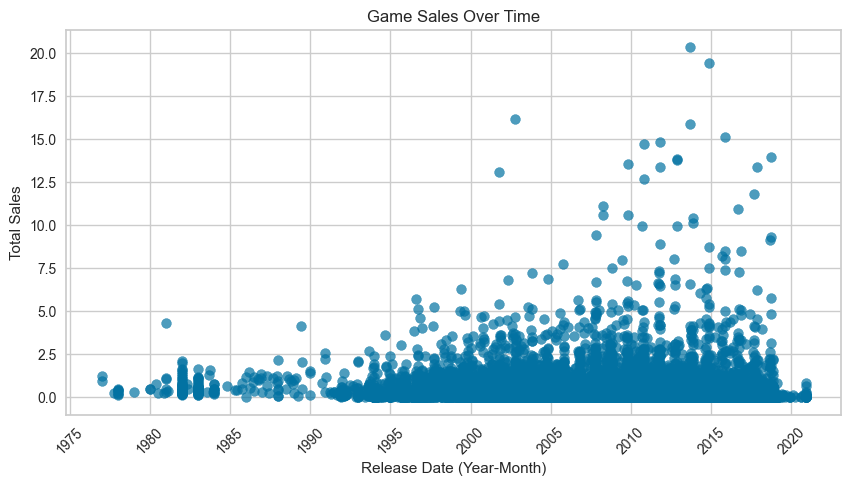

In [137]:
X_clustering = data_general_clean_q2_2.values

plt.figure(figsize=(10,5))
plt.scatter(data_general_clean_q2_2["date"], data_general_clean_q2_2["total_sales"], marker="o", s=50, alpha=0.7)
plt.xlabel("Release Date (Year-Month)")
plt.ylabel("Total Sales")
plt.title("Game Sales Over Time")
plt.xticks(rotation=45)
plt.show()

The video games does cluster based on age and sales, but since allmost all the sales is between 0 and 5 it is difficult to create a meaningful clustering model with this data. this is partly due to many of our obsevations is based only 2 decimals, so small games gets lost.

In [138]:
data_general_clean_q2['date_numeric'] = (data_general_clean_q2['date'] - data_general_clean_q2['date'].min()).dt.days


X_clustering = data_general_clean_q2[['date_numeric', 'total_sales']].values


scaler = StandardScaler()
X_clustering_scaled = scaler.fit_transform(X_clustering)

In [139]:
distortions = []
K = range(2, 12)
for k in K:
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit(X_clustering_scaled)
    distortions.append(
        sum(np.min(cdist(X_clustering_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / X_clustering_scaled.shape[0]
    )

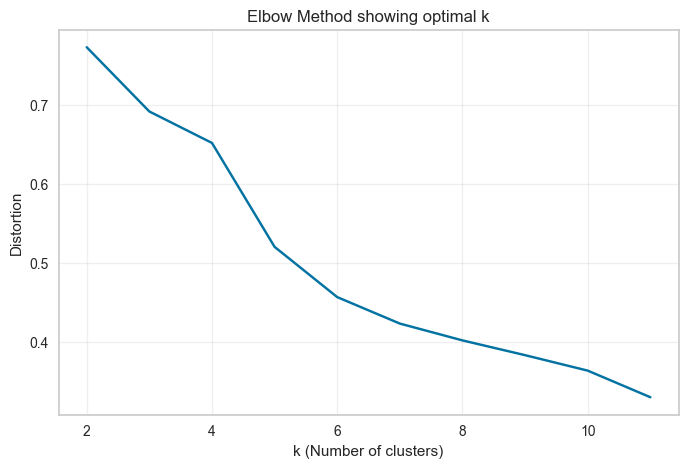

In [140]:
plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k (Number of clusters)')
plt.ylabel('Distortion')
plt.title('Elbow Method showing optimal k')
plt.grid(True, alpha=0.3)
plt.show()

In [141]:
final_model = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
data_general_clean_q2['cluster'] = final_model.fit_predict(X_clustering_scaled)

### Determin K by Silhouette Score

In [142]:
# Determine k by maximising the silhouette score for each number of clusters
scores = []
K = range(2,10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(X_clustering_scaled)
    score = metrics.silhouette_score(X_clustering_scaled, model.labels_, metric='euclidean', sample_size=len(X_clustering_scaled))
    print("\nNumber of clusters =", k)
    print("Silhouette score =", score)
    scores.append(score)


Number of clusters = 2
Silhouette score = 0.43800431599432166

Number of clusters = 3
Silhouette score = 0.45158780154760125

Number of clusters = 4
Silhouette score = 0.4662387243240752

Number of clusters = 5
Silhouette score = 0.4488464548329219

Number of clusters = 6
Silhouette score = 0.4297581098920134

Number of clusters = 7
Silhouette score = 0.449786549725635

Number of clusters = 8
Silhouette score = 0.4464720752926378

Number of clusters = 9
Silhouette score = 0.4554543840517389


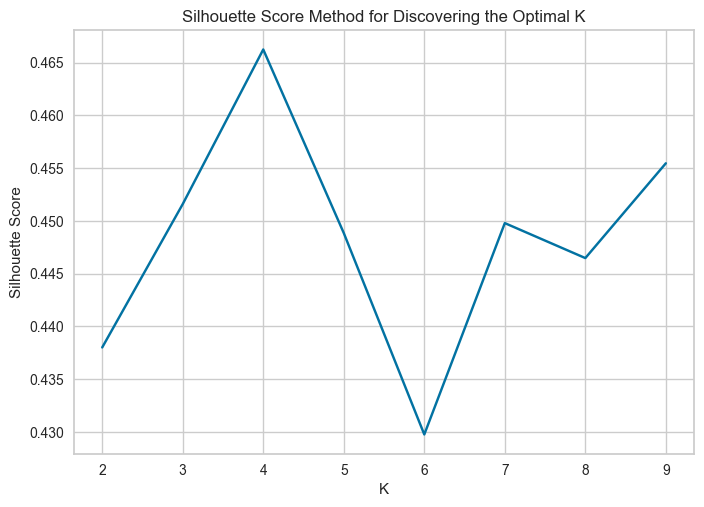

In [143]:
plt.title('Silhouette Score Method for Discovering the Optimal K')
plt.plot(K, scores, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

The diagram shows that the optimal amount of clusters is 4 because it has the highest score of 0.46, but is a weak structure, but close to the 0,5 which is consider a fair structure

In [144]:
optimal_k = 4

In [145]:
kmeans = KMeans(init='k-means++', n_clusters=optimal_k, n_init=20)
# init: method of experimemtal finding the initial location of the centroids
# n_init: the algorithm will run n_init times with different cetroids and the best result of those will be taken

In [146]:
kmeans.fit(X_clustering_scaled)

KMeans(n_clusters=4, n_init=20)

In [147]:
y = kmeans.predict(X_clustering_scaled)
y

array([0, 0, 0, ..., 2, 2, 2], shape=(18832,), dtype=int32)

In [148]:
print(kmeans.labels_)

[0 0 0 ... 2 2 2]


Cluster  0 :  (6755, 2)


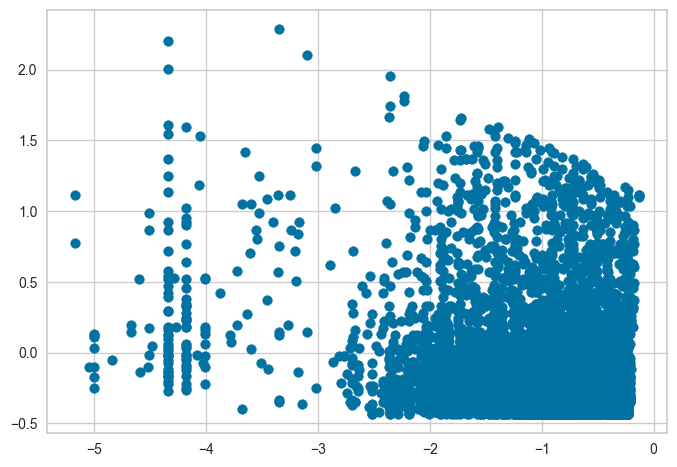

Cluster  1 :  (796, 2)


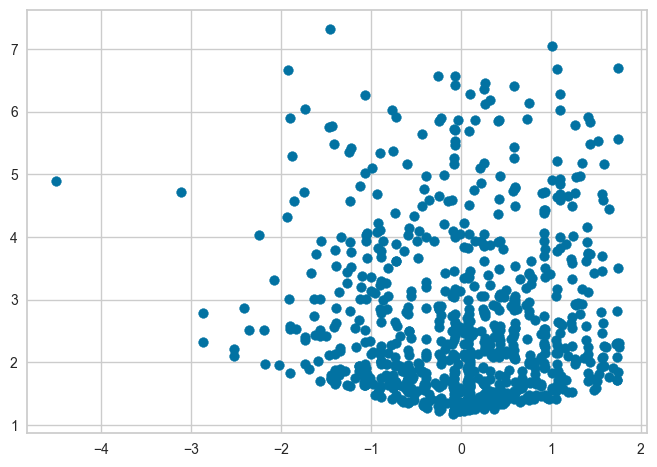

Cluster  2 :  (11224, 2)


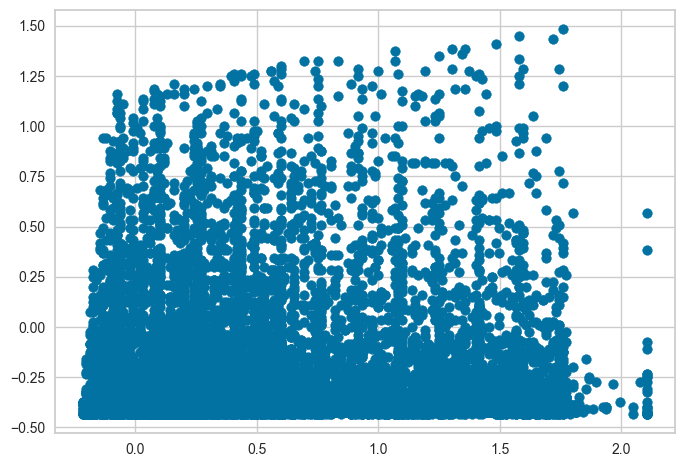

Cluster  3 :  (57, 2)


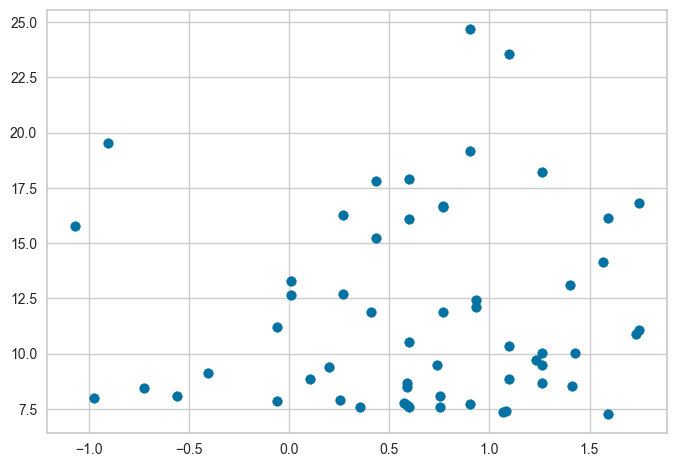

In [149]:
# Clusters seen one by one
for i in range(optimal_k):
    # slice the cluster
    cluster = X_clustering_scaled[y == i]    
    # print the shape
    print("Cluster ", i, ": ", cluster.shape)    
    # plot the points of this cluster
    plt.scatter(cluster[:, 0], cluster[:, 1])   
    plt.grid(True)
    plt.show()

In [180]:
from matplotlib.colors import ListedColormap
cluster_colors = ['#6a0dad', '#ff7f0e', '#1f77b4', '#2ca02c']

cmap = ListedColormap(cluster_colors)

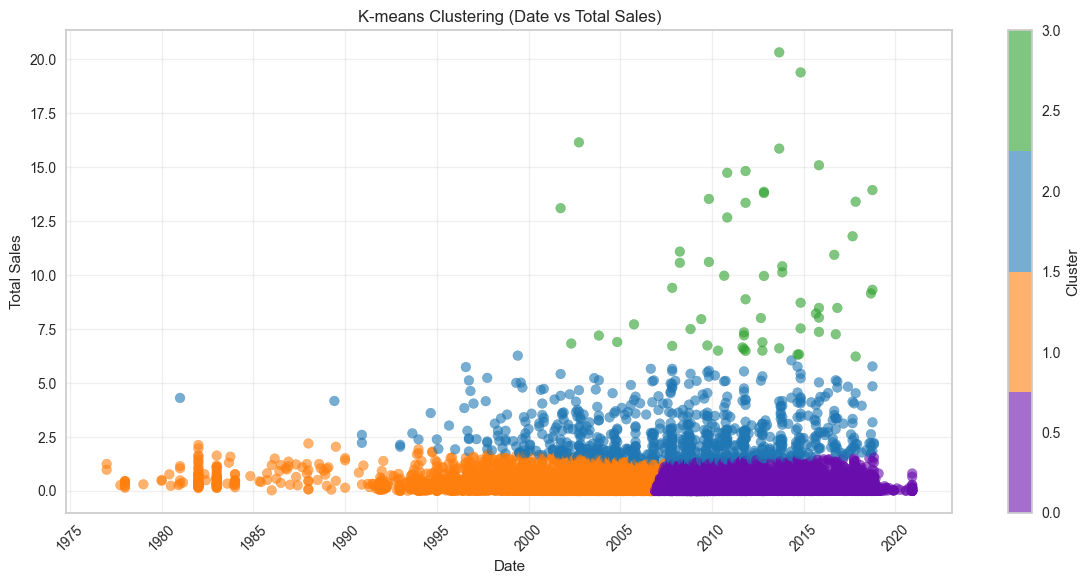

In [181]:
plt.figure(figsize=(12,6))
scatter = plt.scatter(data_general_clean_q2['date'], 
                     data_general_clean_q2['total_sales'], 
                     c=data_general_clean_q2['cluster'], 
                     cmap=cmap, 
                     alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('K-means Clustering (Date vs Total Sales)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [151]:
# See the cluster centres, created during the clustering
# cluster centres are stored in a variable named 'cluster_centers_'
print(kmeans.cluster_centers_)

[[-1.00415462e+00 -9.87065711e-02]
 [ 6.48633660e-03  2.68291560e+00]
 [ 6.00458853e-01 -1.90695791e-01]
 [ 6.62406584e-01  1.18316709e+01]]


### Validate the model

In [176]:
k = 4
KmeansModel = KMeans(n_clusters=k, n_init=10)
KmeansModel.fit_predict(X_clustering_scaled)

array([3, 3, 3, ..., 0, 0, 0], shape=(18832,), dtype=int32)

In [177]:
score = silhouette_score(X_clustering_scaled, KmeansModel.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.466


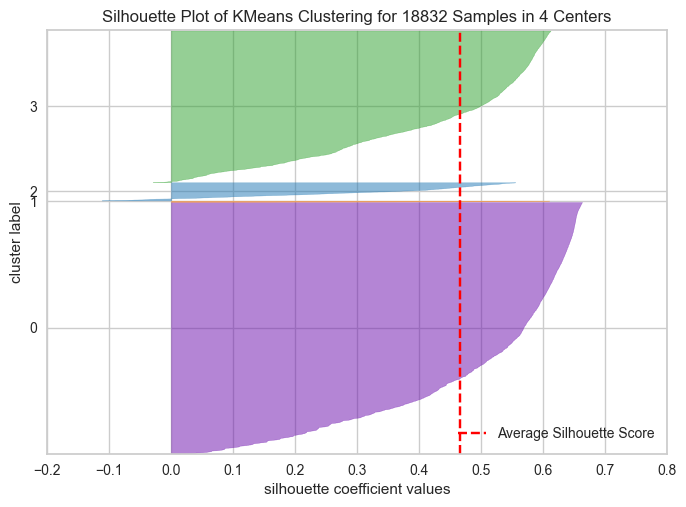

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18832 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
visualizer = SilhouetteVisualizer(KmeansModel, colors=cluster_colors)
visualizer.fit(X_clustering_scaled)
visualizer.show()
# TODO Fix Color - colors does not correlate with above

Interpretation: Each component of the figure represents one cluster with a horisontal bar chart of each cluster point.
Clusters are seen are far from equaly tick and long - similar.
The score is 0.46 - which states that the structure is weak.


## Question 3: Which consoles should a specific genre game be developed for?

In [155]:
# Copy dataset for Q2
data_general_clean_date_q2 = data_general_clean_date.copy()

# Assume your dataframe has columns: 'console', 'genre', 'sales'
# Get all unique consoles and genres
all_consoles = data_general_clean_date_q2['console'].unique()
all_genres = data_general_clean_date_q2['genre'].unique()

# Create a cartesian product of all genre-console combinations
full_index = pd.MultiIndex.from_product([all_genres, all_consoles], names=['genre', 'console'])

# Group your data by genre and console, summing sales
sales_summary = data_general_clean_date_q2.groupby(['genre', 'console'])['total_sales'].sum()

# Reindex to include all combinations, fill missing with 0
sales_summary = sales_summary.reindex(full_index, fill_value=0).reset_index()

In [156]:
# Determine the maximum sales across all genre-console combinations
max_sales = sales_summary['total_sales'].max()

In [157]:
fig = px.bar(
    sales_summary,
    x="console",
    y="total_sales",
    animation_frame="genre",
    labels={
        "total_sales": "Total Sales",
        "console": "Console",
        "genre": "Genre"
    },
    title="Sales per Console Animated by Genre"
)

# Keep x-axis fixed with all consoles
fig.update_xaxes(categoryorder="array", categoryarray=list(all_consoles))

fig.update_yaxes(range=[0, max_sales * 1.05])  # small buffer on top

fig.show()

We had expected to see more sales for PC, we speculate the dataset is incomplete and doesn't reflect the real world scenario in this case. We had previously cleaned the dataset and there were thousands of rows with no data for sales, which we removed.

## Question 4: How can trends be predicted so that a game is released when its genre is popular? 

In [158]:
sales_summary_q3 = (
    data_general_clean_date.groupby(['year', 'genre'], as_index=False)['total_sales'].sum()
)

all_years = sales_summary_q3['year'].unique()
all_genres = sales_summary_q3['genre'].unique()

# Create full combination of year x genre
full_index = pd.MultiIndex.from_product([all_years, all_genres], names=['year', 'genre'])
sales_summary_q3 = sales_summary_q3.set_index(['year','genre']).reindex(full_index, fill_value=0).reset_index()

fig = px.bar(
    sales_summary_q3,
    x="year",
    y="total_sales",
    animation_frame="genre",
    labels={
        "total_sales": "Total Sales",
        "year": "Release Year",
        "genre": "Game Genre"
    },
    title="Total Game Sales per Year Animated by Genre",
    color="genre"  # optional, or remove if you don’t want color distinction
)

# Fix x-axis so all years are always shown
fig.update_xaxes(categoryorder="array", categoryarray=sorted(all_years))

# Optionally fix y-axis so bars don’t get cut off
fig.update_yaxes(range=[0, sales_summary_q3['total_sales'].max() * 1.05])

fig.show()


We can see that aren't really any yearly trends for genres of games, we can generally see that there are some genres that are more popular than others.

## Question 5: Which game genres sell better in which regions, so that companies know where to market their games?

In [159]:
# Columns that represent regions
region_columns = ['na_sales', 'jp_sales', 'pal_sales', 'other_sales']

# Melt into long format: region + sales
df_long = data_general_clean_date.melt(
    id_vars=['title','console','genre','publisher','developer','critic_score', 'total_sales' ,'release_date'],
    value_vars=region_columns,
    var_name='region',
    value_name='sales'
)

# Optional: make region names prettier
df_long['region'] = df_long['region'].str.replace('_sales', '').str.upper()

sales_summary_q4 = df_long.groupby(['genre','region'], as_index=False)['sales'].sum()

all_genres = data_general_clean_date['genre'].unique()
all_regions = ['NA','JP','PAL','OTHER']

full_index = pd.MultiIndex.from_product([all_genres, all_regions], names=['genre','region'])
sales_summary_q4 = sales_summary_q4.set_index(['genre','region']).reindex(full_index, fill_value=0).reset_index()

fig = px.bar(
    sales_summary_q4,
    x="genre",
    y="sales",
    animation_frame="region",
    labels={
        "sales": "Total Sales",
        "genre": "Game Genre",
        "region": "Region"
    },
    title="Total Game Sales by Genre Animated by Region",
    color="genre"
)

# Keep x-axis fixed
fig.update_xaxes(categoryorder="array", categoryarray=list(all_genres))

# Fix y-axis so bars are never cut off
fig.update_yaxes(range=[0, sales_summary_q4['sales'].max() * 1.05])

fig.show()

We can see that the NA region has higher sells in all genres, JP and OTHER has almost none and PAL has a few. So we can conclude that all genres will most likely sell better in NA. And while Action, shooter and Sports are highest in every almost every region, it seems that JP is mosttly into Role-Playing.

## Question 6: We assume that the combination of categorical features in the dataset (such as genre, console, publisher, and developer) contains enough information to predict a game’s total sales before launch. Therefore, we expect that a machine learning model, such as a Random Forest, will be able to generate reasonably accurate predictions of sales based solely on these features.

In [160]:
data_general_clean_q6 = data_general_clean_date[["console","genre", "publisher", "developer", "month", "year", "total_sales"]].copy()

In [161]:
array = data_general_clean_q6.values

array

array([['PS3', 'Action', 'Rockstar Games', ..., 9, 2013, 20.32],
       ['PS4', 'Action', 'Rockstar Games', ..., 11, 2014, 19.39],
       ['PS2', 'Action', 'Rockstar Games', ..., 10, 2002, 16.15],
       ...,
       ['PC', 'Platform', 'THQ', ..., 10, 2004, 0.0],
       ['GBA', 'Platform', 'Telegames', ..., 10, 2002, 0.0],
       ['DS', 'Role-Playing', 'D3 Publisher', ..., 1, 2007, 0.0]],
      shape=(18922, 7), dtype=object)

In [162]:
X, y = array[:, :-1], array[:, -1]

In [196]:
max_value = data_general_clean['total_sales'].max()
min_value = data_general_clean['total_sales'].min()

print(f"Max: {max_value}, Min: {min_value}")

Max: 20.32, Min: 0.0


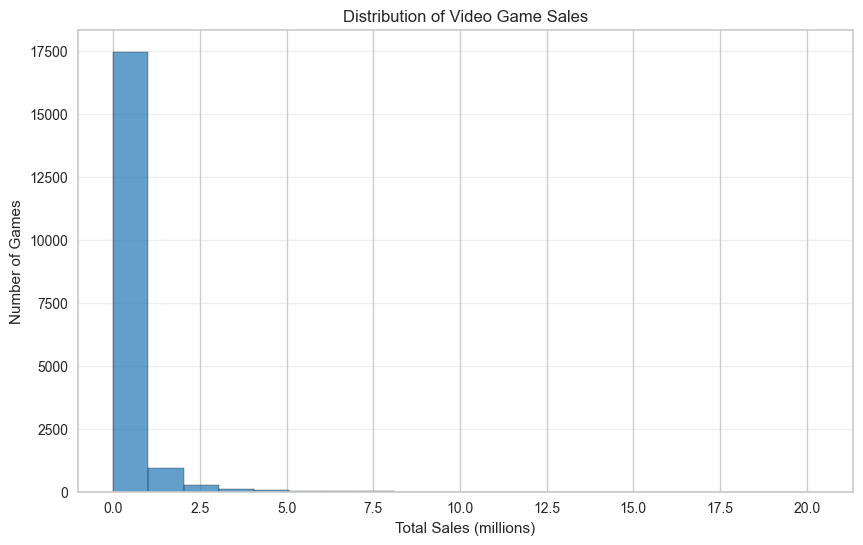

In [193]:
plt.figure(figsize=(10,6))
plt.hist(data_general_clean['total_sales'], bins=20, color='#1f77b4', edgecolor='black', alpha=0.7)
plt.xlabel('Total Sales (millions)')
plt.ylabel('Number of Games')
plt.title('Distribution of Video Game Sales')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
bins = [0, 5, 10, 15, 20, np.inf]
labels = ['0-5', '5-10', '10-15', '15-20']

In [167]:
# Create new classification column
data_general_clean['sales_score'] = pd.cut(data_general_clean['total_sales'], bins=bins, labels=labels, right=False)

# Convert to numeric for classification
data_general_clean['sales_score_numeric'] = pd.cut(data_general_clean['total_sales'], bins=bins, labels=False, right=False)

In [ ]:
# Instead of using 'diag' as target:
# y = array[:, -1]  # Last column (diag)

# Use your custom classification:
y = data_general_clean['sales_score_numeric'].values
X = data_general_clean.drop(['sales_score', 'sales_score_numeric'], axis=1).values

In [ ]:
# Separate input data
lowSale = np.array(X[y==0])
lowMiddleSale = np.array(X[y==1])
middleHighSale = np.array(X[y==2])
highSale = np.array(X[y==3])

### Training

In [172]:
set_prop = 0.15
seed = 12

In [197]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

In [198]:
classifier = RandomForestClassifier(n_estimators = 100, max_depth = 6)

In [199]:
classifier.fit(X_train, y_train)

ValueError: could not convert string to float: '/games/boxart/full_7128798AmericaFrontccc.jpg'